# COGS 108 - Final Project 

# Overview

The intention of this project is to research whether ther is any form of correlation between the Health Inspection Scores that facilities may recieve as an effec to their general proximity to other facilites. The data used in the project, revolved around food faciliteis that are present in North Carolina. In order to approach the question that relates to the geographical information, we used geospatial analysis that made use of data points present in the inspections dataset. The training and testing sets did not offer clear correlation between the two variables. This based on the fact that that there is a skewed distribution of scores. We continued our analysis by using a linear model.  The model demonstrated that there was relationship between the variables by prvoing the null hypothesis incorrect. 

# Name & PID

- Name: Odalys Juarez
- GitHub Username: ojuare018

# Research Question

Is there a relationship between a Food Establishment's Health Inspection Score and their proximity to other restaurants?

## Background and Prior Work

Research regarding the specific relationship between an establishment's Health Inspection Score and its location near highly other establishements has not been conducted as of yet. Looking into data that may aid into helping find correlations between these two variables will include understanding the rating system used in the state of North Carolina. Information to this can be viewed in the public OLR Reseacrh Report that details the grading and requirements for retail food facilities. Health Inspections conducted by Inspectors run on a one hundred point system. At the beginning of the inspection, the restaurant starts with one hundred points. If violations are found, points will be subtracted from the one hundred score. A letter grade is assigned from the total score. Letter ranges are:
- A (100 - 90)
- B (89 - 80)
- C (79 - 70)
- Given Score (69 and below)

Scores lower than 69 will simply be assigned their score. 

The only relevant source found was one regarding research conducted by to understand the relationship between the frequency of health inspections and restaurant sociodemographic characteristics to the food safety inspection outcomes in both chain and non-chain establishments. Variable that were used were restaurant type, inspection frequency, and violation type. Results from the study concluded that chain establishments had fewer violations during inspections. They wanted to understand whether one could predict a restaurants inspection score based on whether it was related to a chain or not. Their results are interesting in regard to my research question since I want to find associations between an establishments Health Inspection score and location. I believe that location is a factor on an establishments score being that most chain establishments would push to find locations near more regularly populated areas. Being part of a chain will also require maintenance to conserve brand image and popularity. This represents a difference between locally inclined restaurants and restaurants meant for mainly any form of customer.

References (include links):
- 1)https://cga.ct.gov/2005/rpt/2005-R-0403.htm
- 3)https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5349477/
- 4)https://www.chinahighlights.com/travelguide/article-local-restaurants.htm

# Hypothesis


A restaurant’s Health Inspection score would be higher based on its proximity near other food establishement due to competition between restaurants. Inorder to have a lead on nearby competition, restaurants will need to adhere to Health Requirements in order to have an attracting factor for potential clientele.

# Dataset(s)

- Dataset Name: inspections.csv
- Link to the dataset: Provided CSV files
- Number of observations: 12694

The dataset inludes information regarding the inspections of select faclities in North Carolina. In the dataset there are a total of 15365 observations, that include Health Inspection Scores the inspector who awared the score.

# Setup

In [1]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 5)
plt.rcParams.update({'font.size': 16})
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

import shapely.geometry as shp

import sklearn.neighbors as skn
import sklearn.metrics as skm

import scipy.spatial as spatial

from sklearn.neighbors import KernelDensity

from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

pd.options.display.max_rows = 10

#improve resolution
#comment this line if erroring on your machine/screen
%config InlineBackend.figure_format ='retina'

# Data Cleaning

Below, we read the Inspection dataset CSV file that contains variables of interest.

In [2]:
rep = pd.read_csv('inspections.csv')

Here we create a dataframe that includes the variable of interest we are interested in investigating that are the coordinate point x and y, the Health Inspection score and facility type. Additionally we use the x and y coordinates to geospatially map datapoints onto a map an view their distribution 

In [3]:
#Creating Dataframe with selected variables
rep = rep[['x','y','geocodestatus', 'score', 'facilitytype']]

In [4]:
# adding Geometry column
geometry = [Point(xy) for xy in zip(rep['x'], rep['y'])]

# Here, we adminiter the Coordinate reference system : WGS84 in order to plot points on map.
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame 
gdf = gpd.GeoDataFrame(rep, crs=crs, geometry=geometry)


/home/omjuarez/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


The research question we stated was in relation to food service establishments that are open to the general public and are not markets places. In order for our data to reflect these conditions we will simply create a dataframe that includes the facility types that we are interested. This will result in our dataframe only including facility types that include Restaurants, Food Stands, and Pushcarts. 

In [5]:
gdf = gdf[(gdf.facilitytype == 'Restaurant') | (gdf.facilitytype == 'Food Stand') | (gdf.facilitytype == 'Pushcarts')]
gdf.shape

(15365, 6)

In order to include more variables for our attribute model we will replace facility type with a numerical represention. Here Restaurant is represented as 1, Food Stand will be represented as a 2, and Pushcarts as 3.

In [6]:
gdf['facilitytype'] = gdf['facilitytype'].replace('Restaurant', 1)
gdf['facilitytype'] = gdf['facilitytype'].replace('Food Stand', 2)
gdf['facilitytype'] = gdf['facilitytype'].replace('Pushcarts', 3)

# Data Analysis & Results

We will graph the distribution of the facilities across the Norh Carolina state using geographical visualizations. Below we plot the points.

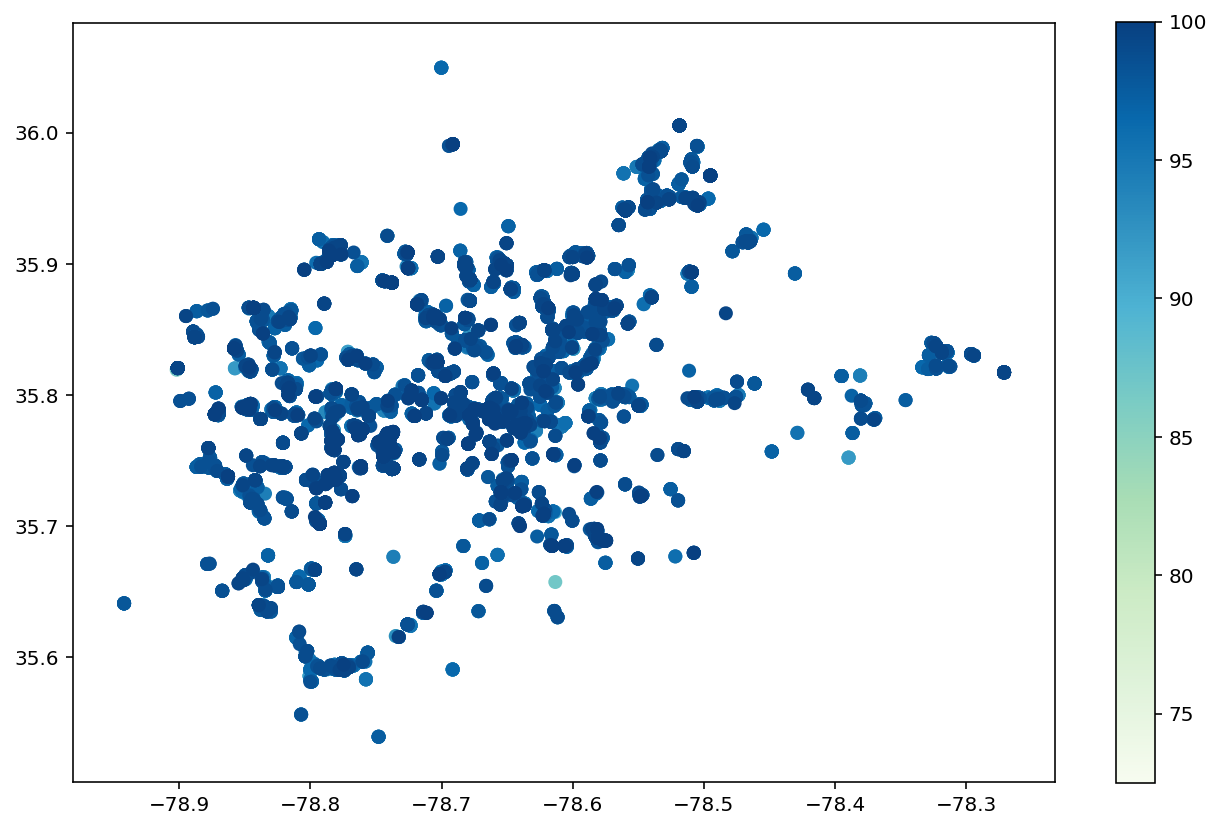

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(11, 7))
divider = make_axes_locatable(ax)
gdf.sort_values('score').plot('score', cmap='GnBu', figsize=(20, 36), ax=ax, legend=True);

In order to find the Kernal Density of a coordinate point that is dependent on its proximity to other points we will use the kde Kernel Density Estimation that using the Guassian kernel. Before we do that, we will create a numpy array of the coordinates in the dataframe. 

In [8]:
arr = gdf[['x', 'y']].to_numpy()

#Identify Kernal Density based on proximity to other points
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(arr)
density = kde.score_samples(arr)

Given the estimated density of each point, we will add the density array as a cloumn on the Dataframe. 

In [9]:
gdf['density']=pd.Series(density)
gdf.dropna()

,x,y,geocodestatus,score,facilitytype,geometry,density
0,-78.587963,35.783914,M,96.0,1,POINT (-78.58796 35.78391),1.072187
1,-78.549673,35.791986,M,98.0,1,POINT (-78.54967 35.79199),0.992672
2,-78.547960,35.723125,M,97.0,1,POINT (-78.54796 35.72313),0.901594
3,-78.815727,35.799249,M,99.0,1,POINT (-78.81573 35.79925),0.999501
4,-78.296347,35.831285,M,97.0,2,POINT (-78.29635 35.83129),-0.215566
...,...,...,...,...,...,...,...
15360,-78.744273,35.753236,M,99.5,1,POINT (-78.74427 35.75324),1.060559
15361,-78.314731,35.833413,M,97.0,1,POINT (-78.31473 35.83341),1.094592
15362,-78.681845,35.841838,T,90.5,1,POINT (-78.68184 35.84184),1.088541
15363,-78.772059,35.592552,M,80.0,1,POINT (-78.77206 35.59255),0.629715


Using the density data, we will try to use the KNeighborsRegressor model in order to create Training and testing model that could potentially predict whether a restaurant's proximity to numerous other food faciliteis has an effect on the Health Inspection score that the Restaurant recieves. We will use attributes of interest that include score, density, and facility type.

In [10]:
# get data for attributes model
model_data = gdf[['score','density','facilitytype']].dropna()

# Here we specify the predictors (X) and outcome (y)
Xnames = ['density']
X = model_data[Xnames].values
X = X.astype(float)
y = np.log(model_data[['score']].values)

We will use the coordinate values from out our dataframe.

In [11]:
#Coordinates of resturants as 
coor = gdf[['x', 'y']].to_numpy()
coor

array([[-78.587963,  35.783914],
       [-78.549673,  35.791986],
       [-78.54796 ,  35.723125],
       ...,
       [-78.601215,  35.848466],
       [-78.781507,  35.594405],
       [-78.571592,  35.865463]])

In [12]:
# Set the training and test set
shuffle = np.random.permutation(len(y))
num = int(0.8*len(shuffle))
train, test = shuffle[:num],shuffle[num:]

# spatial Model
KNNR = skn.KNeighborsRegressor(weights='distance', n_neighbors=100)
spatial = KNNR.fit(coor[train,:],
                  y[train,:])
# generate predictions in the training set
sp_ypred_train =  spatial.predict(coor[train,:])  # spatial

In [13]:
# Here we generate predictions in the training set
sp_ypred_train =  spatial.predict(coor[train,:])  # spatial

# variance explained in training data
(skm.explained_variance_score(y[train,], sp_ypred_train))

0.4274034610032341

In [14]:
# generate predictions in the test set
sp_ypred =  spatial.predict(coor[test,:])

(skm.explained_variance_score(y[test,], sp_ypred))

0.2727690371326379

Based on the results of the predication rates in the training and the testing sets, density does not seem to be a particularly good predictor for Health Inspection Scores for restaurants. Taking a closer look at the distribution of scores, we see that there score distribution is skewed, containing values that may be affecting the the prediction models.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


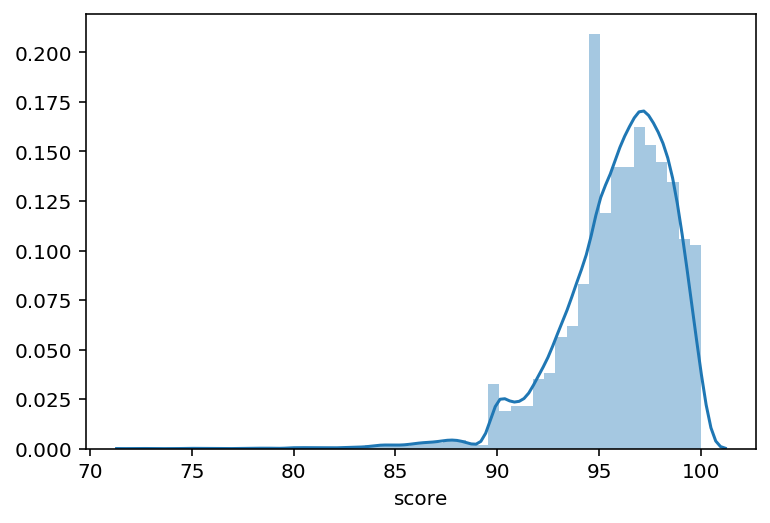

In [15]:
# distribution of price
sns.distplot(gdf['score']);

Seeing that the data is particularly skewed causing anomalies that maybe affecting the overall distribution, but not wanting to retract the values due to this potentially being important to the analysis, we will then make use of a linear model. We will see whether density helps predict for Health Inspection Scores. Below we will set the predicitor as density, which as previously stated reflects the proximity between other points, and the outcome being Inspection Score. 

The null hypothesis for the following being that density does not predict for the Health Inspection Score.

In [16]:
outcome_1, predictors_1 = patsy.dmatrices('score ~ density', gdf)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()

Below, we see the summary results of the model

In [17]:
print(res_1.summary())
np.set_printoptions(suppress=True)
print(np.asarray(res_1.pvalues))

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.09903
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.753
Time:                        22:52:58   Log-Likelihood:                -30446.
No. Observations:               12694   AIC:                         6.090e+04
Df Residuals:                   12692   BIC:                         6.091e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     95.9949      0.104    921.637      0.0

Using an alpha of 0.1, we reject the null hypothesis, which means that there does seem to be a correlation between density and Health Inspection scores.

# Ethics & Privacy

Data found on the on the dataset is open source information available to the public. Awareness of a facility's Health Inspection Score is essesntial in allowing the public to undestand the sanitary conditions of the establishement when they enter the premises. Information with further specifying identifiers were eliminated inorder to provide the owners of the facilities in the dataset a source of privacy. This is also done with information regarding the inspectors that administered these scores. As demonstrated in the data cleaning portion of this paper, columns with critical information where removed. Only data regarding location, score, and facility type were preserved.

A facilities location of origin may be subject to concerns of privacy. In order to fix these future concerns, these will be eliminated once made aware of them. Age and sex of the inspector or the facility ownere are not considered in dataset due to it including components not deemed important in restaurant’s overall evaluation. This is also done with the interest of save guarding an individual’s identity. No other information regarding the individual will be collected unless they become prevalent. Further concerns for privacy will be evaluated and considered for omission in dataset.


# Conclusion & Discussion

From the results, we see that there does seem to be a correlation between facility proximity to other food establishments and the Health Inspection Score that they recieve. The linear model used contains a value that is higher than the alpha which means that we reject the null hypothesis that states that there is no correlation between the variables. The presence of higher desity suggests that was calulated through the kde Kernel Density Estimation that using the Guassian kernel, demonstrated that Score depend on that variable. 

Limitaition to the project regarded comfortability with the python programming language and in geospatial analysis. Other forms of geospatial anaysis could have been used in order to get more precise results. In the furture, it would aid in the analysis to compare the data with other sataes in order to see whether the results are specific to the state or not. A site of interest could be California as it is near the Pacific Ocean were toursim may be higher. Using a linear model may not have helped better understand the dataset, other methods may be essential to condensing the information. 